In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
import random

In [15]:
data_path = "../data/experiment1-3d"

In [148]:
measures = pd.read_csv(os.path.join(data_path, "measures.csv"), index_col=["subj_id", "session", "route", "intersection_no"])
processed_data = pd.read_csv(os.path.join(data_path, "processed_data.csv"), index_col=["subj_id", "session", "route", "intersection_no"])

In [105]:
len(measures.index.get_level_values("subj_id").unique())

10

In [90]:
def plot_traj(traj, traj_id):
    idx_truck_moving = traj.truck_v.to_numpy().nonzero()[0][0]
    idx_bot_moving = traj.bot_v.to_numpy().nonzero()[0][0]
    idx_bot_visible = idx_bot_moving + np.argmax(traj.bot_angle[idx_bot_moving:] - traj.truck_angle[idx_bot_moving:] < 0)

    fig, axes = plt.subplots(5, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t[idx_truck_moving:], traj.ego_v[idx_truck_moving:], color="C0")
    axes[0].plot(traj.t[idx_truck_moving], traj.ego_v[idx_truck_moving], color="C7", ls="", marker="o")
    axes[0].plot(traj.t[idx_bot_moving], traj.ego_v[idx_bot_moving], color="C7", ls="", marker="s")
    axes[0].plot(traj.t[idx_bot_visible], traj.ego_v[idx_bot_visible], color="C7", ls="", marker="x")
    axes[0].set_ylabel("ego v")

    axes[1].plot(traj.t[idx_truck_moving:], traj.throttle[idx_truck_moving:], color="C1")
    axes[1].plot(traj.t[idx_truck_moving], traj.throttle[idx_truck_moving], color="C7", ls="", marker="o")
    axes[1].plot(traj.t[idx_bot_moving], traj.throttle[idx_bot_moving], color="C7", ls="", marker="s")
    axes[1].plot(traj.t[idx_bot_visible], traj.throttle[idx_bot_visible], color="C7", ls="", marker="x")
    axes[1].set_ylabel("ego throttle")

    axes[2].plot(traj.t[idx_truck_moving:], traj.d_ego_bot[idx_truck_moving:], color="C2")
    axes[2].plot(traj.t[idx_truck_moving], traj.d_ego_bot[idx_truck_moving], color="C7", ls="", marker="o")
    axes[2].plot(traj.t[idx_bot_moving], traj.d_ego_bot[idx_bot_moving], color="C7", ls="", marker="s")
    axes[2].plot(traj.t[idx_bot_visible], traj.d_ego_bot[idx_bot_visible], color="C7", ls="", marker="x")
    axes[2].set_ylabel("d(ego to bot)")

    axes[3].plot(traj.t[idx_truck_moving:], traj.tta[idx_truck_moving:], color="C3")
    axes[3].plot(traj.t[idx_truck_moving], traj.tta[idx_truck_moving], color="C7", ls="", marker="o",
                 label="Truck starts moving")
    axes[3].plot(traj.t[idx_bot_moving], traj.tta[idx_bot_moving], color="C7", ls="", marker="s",
                 label="Bot starts moving")
    axes[3].plot(traj.t[idx_bot_visible], traj.tta[idx_bot_visible], color="C7", ls="", marker="x",
                 label="Bot visible")
    axes[3].axhline(4.5, color="grey", ls="--")
    axes[3].axhline(5.5, color="grey", ls="--")
    axes[3].set_ylabel("tta")
    # axes[3].set_ylim((0, 7))

    axes[4].plot(traj.t[idx_truck_moving:], traj.bot_v[idx_truck_moving:], color="C6")
    axes[4].plot(traj.t[idx_bot_visible], traj.bot_v[idx_bot_visible], ls="", marker="x", color="C7")
    axes[4].set_ylabel("bot v")

    # plt.plot(traj.t[idx_bot_moving:], traj.bot_angle[idx_bot_moving:]-traj.truck_angle[idx_bot_moving:])
    # plt.plot(traj.t[idx_bot_visible], traj.bot_angle[idx_bot_visible]-traj.truck_angle[idx_bot_moving+idx_bot_visible], marker='o')
    # plt.axhline(0.0, color="grey", ls="--")
    #
    # axes[5].plot(traj.t, traj.bot_angle, label="visual angle to the bot")
    # axes[5].plot(traj.t, traj.truck_angle, label="visual angle to the edge of the truck")
    # axes[5].plot(traj.t[idx_truck_moving:], traj.truck_angle[idx_truck_moving:], color="C4", label="Ego-truck angle")
    # axes[5].plot(traj.t[idx_truck_moving:], traj.bot_angle[idx_truck_moving:], color="C5", label="Ego-bot angle")
    # axes[5].legend()
    # axes[5].set_ylim((-0.1, 0.1))

    axes[-1].set_xlabel("time $t$")

    legend = fig.legend(loc="upper left", bbox_to_anchor=(1.0, 0.9), title=str(traj_id))
    legend.get_title().set_fontsize("18")
    plt.tight_layout()

    return fig, axes

Some participants apparently defaulted to "open-loop" behavior - stop behind the truck, then take the turn without considering the oncoming car. This means they didn't really make gap acceptance decisions so we'll probably need to exclude those

(642, 1, 1, 26)


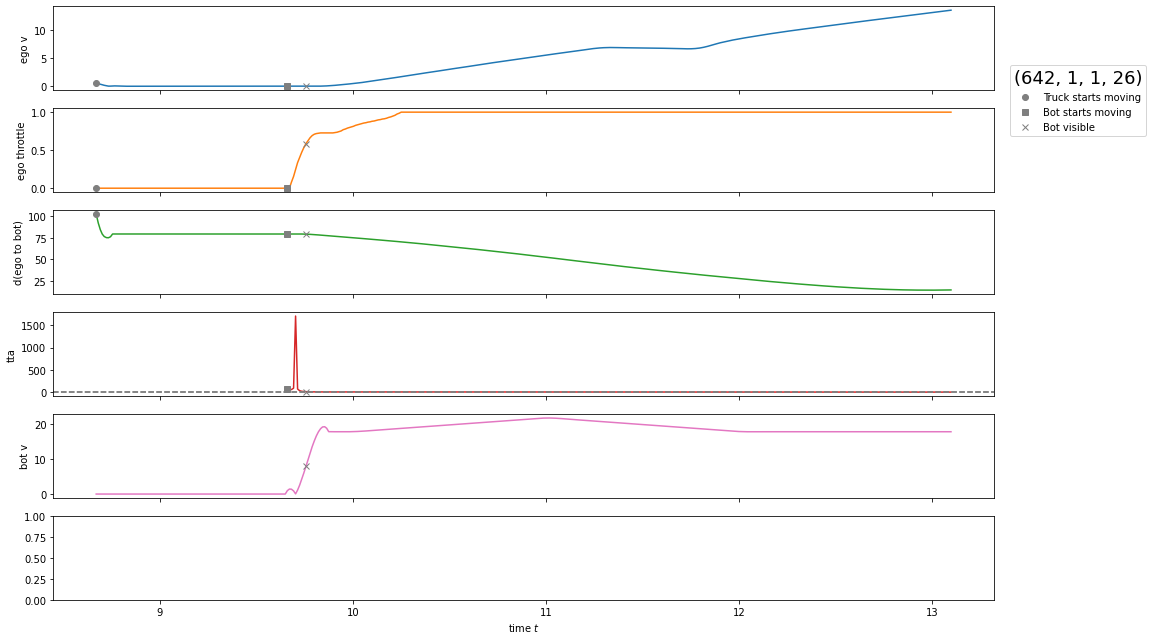

In [89]:
# normal trajectory
# traj_id = (200, 1, 1, 4)

# traj_id = random.choice(measures[(measures.RT>0.0) & (measures.RT<0.1) & (measures.is_go_decision)].index)
print(traj_id)
traj = processed_data.loc[traj_id].reset_index()
plot_traj(traj, traj_id);

In [93]:
def get_early_response_rate(subj_measures):
    return len(subj_measures[(measures.RT==0) & (measures.is_go_decision)]) / len(subj_measures[subj_measures.is_go_decision])

measures.groupby("subj_id").apply(get_early_response_rate)

C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_5996\2560366094.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return len(subj_measures[(measures.RT==0) & (measures.is_go_decision)]) / len(subj_measures[subj_measures.is_go_decision])


subj_id
200    0.527950
295    0.000000
390    0.021277
425    0.100917
450    0.050000
576    0.319149
642    0.192982
697    0.108108
752    0.000000
946    0.403846
dtype: float64

In [94]:
measures.groupby("subj_id").apply(lambda m: len(m[m.is_go_decision]) / len(m))

subj_id
200    0.805
295    0.065
390    0.235
425    0.545
450    0.300
576    0.235
642    0.570
697    0.740
752    0.115
946    0.780
dtype: float64

D:\source\cognitive-av\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Probability of go')

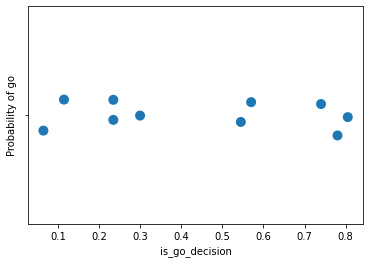

In [96]:
ax = sns.stripplot(measures.groupby("subj_id").is_go_decision.mean(), size=10)
ax.set_ylabel("Probability of go")

# Response times

Proportion of stay trials without missing RT

In [104]:
len(measures[(measures.RT<=0) & ~measures.is_go_decision])/len(measures[~measures.is_go_decision])

0.03892493049119555

<AxesSubplot: >

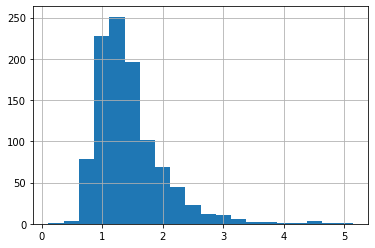

In [101]:
measures[~measures.is_go_decision & (measures.RT>0)].RT.hist(bins=20)

Proportion of go trials with premature response

In [103]:
len(measures[(measures.RT<=0) & measures.is_go_decision])/len(measures[measures.is_go_decision])

0.2496954933008526

<AxesSubplot: >

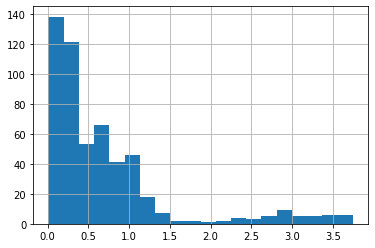

In [149]:
measures[measures.is_go_decision & (measures.RT>0)].RT.hist(bins=20)

# Changes of mind

In [150]:
measures[measures.is_go_decision & (measures.RT_yield>0)].groupby("a_condition").size()

a_condition
[0.0, -4, -4, 0.0]    44
[0.0, -4, 4, 0.0]      2
[0.0, 4, -4, 0.0]      1
dtype: int64

In [117]:
measures[~(measures.is_go_decision) & (measures.RT_yield>measures.RT_gas)].reset_index().groupby("subj_id").size()

subj_id
200    28
295    24
390    15
425    58
450    34
576    64
642    24
697    38
752     1
946    42
dtype: int64

# Measure plots

In [118]:
measures = measures.reset_index()

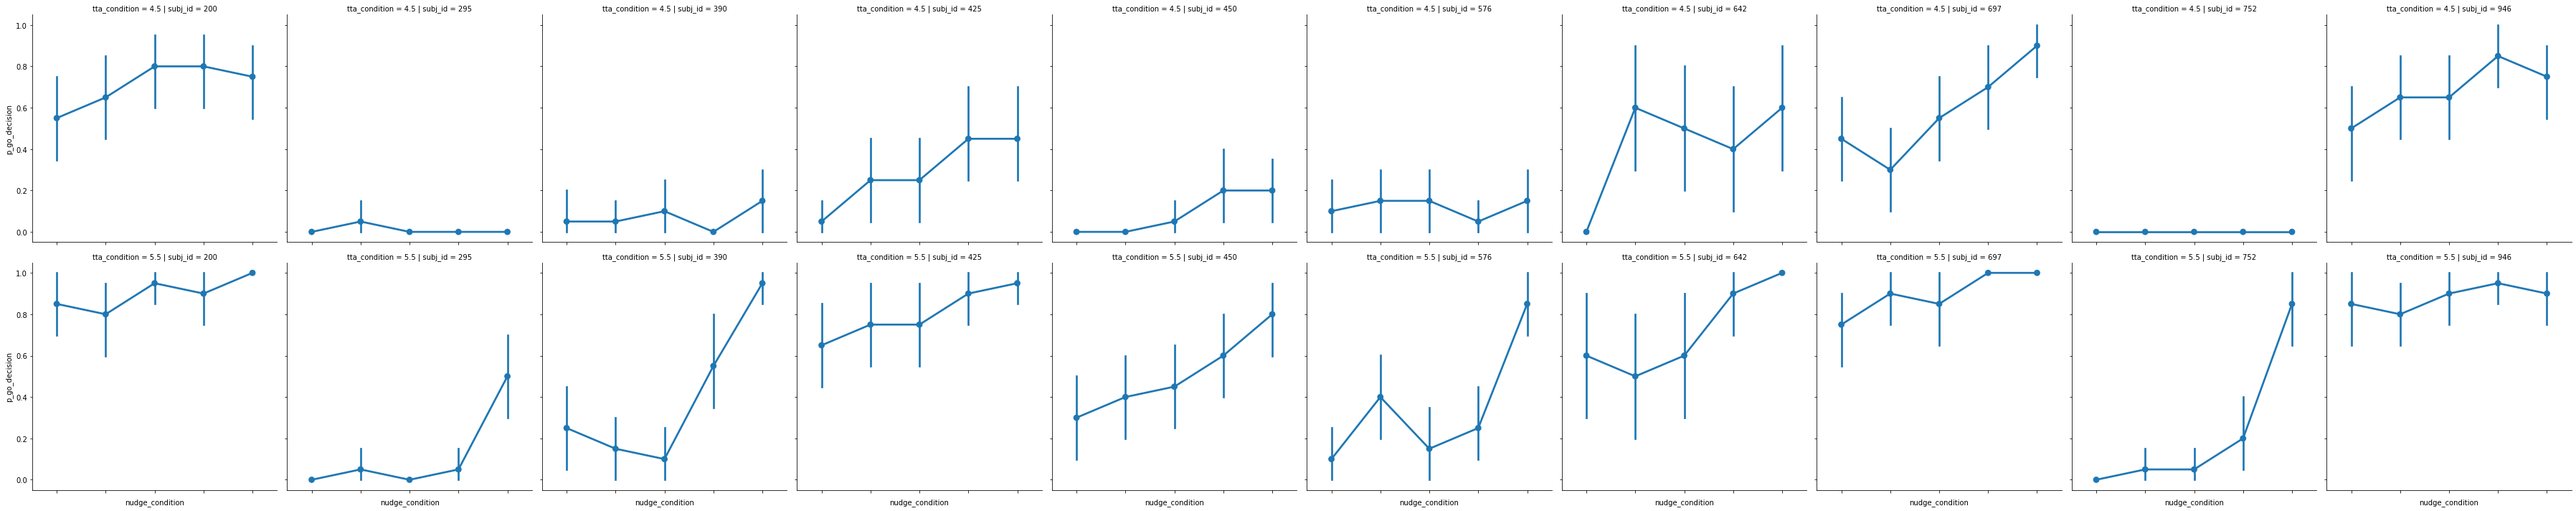

In [120]:
g = sns.catplot(data=measures, x="nudge_condition", y="p_go_decision", row="tta_condition", col="subj_id", kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("../figures/p_go.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


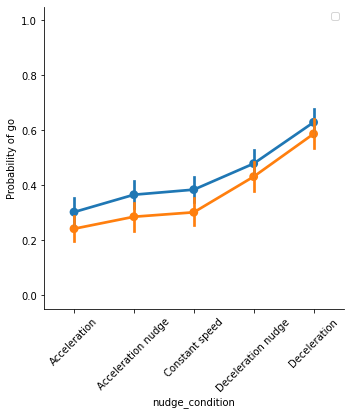

In [130]:
g = sns.catplot(data=measures, x="nudge_condition", y="p_go_decision", # col="tta_condition",
                kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])

for axes in g.axes:
    for ax in axes:
        # sns.pointplot(data=measures[measures.RT>0], x="nudge_condition", y="p_go_decision", ax=ax,             order=["Acceleration",
        #            "Acceleration nudge",
        #            "Constant speed",
        #            "Deceleration nudge",
        #            "Deceleration"], color="C1")
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Probability of go")

# Response times

1700


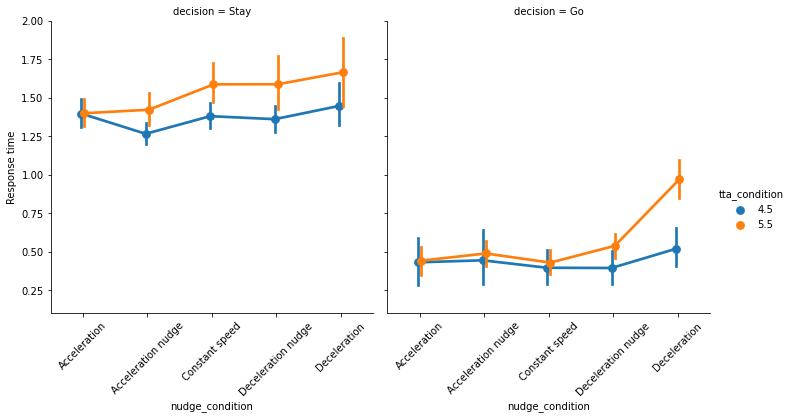

In [155]:
# Plot all RTs
# data = measures

# Excluding stay->go changes-of-mind (almost exclusively observed in the deceleration condition)
data = measures.copy()
data.loc[(data.is_go_decision) & (data.RT_yield > 0), "RT"] = data[(data.is_go_decision) & (data.RT_yield > 0)].RT_yield

print(len(data))
g = sns.catplot(data=data[data.RT>0], x="nudge_condition", y="RT", hue="tta_condition", col="decision",
                kind="point", dodge=True,
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])

for axes in g.axes:
    for ax in axes:
        ax.set_ylim((0.1, 2.0))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Response time")

# Subjective ratings

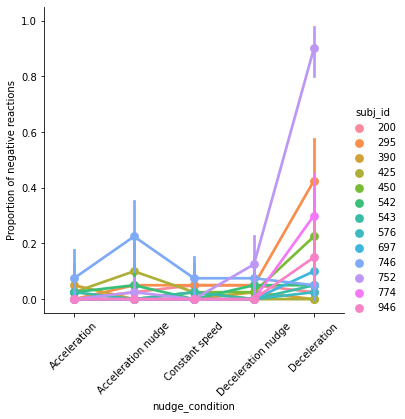

In [16]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", kind="point", hue="subj_id",
               order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])

for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")


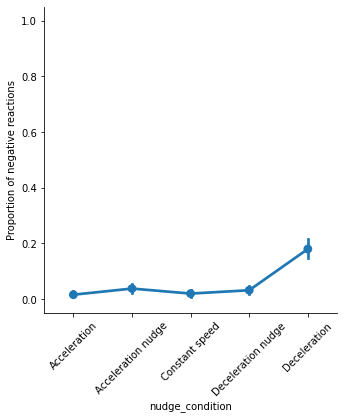

In [17]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")

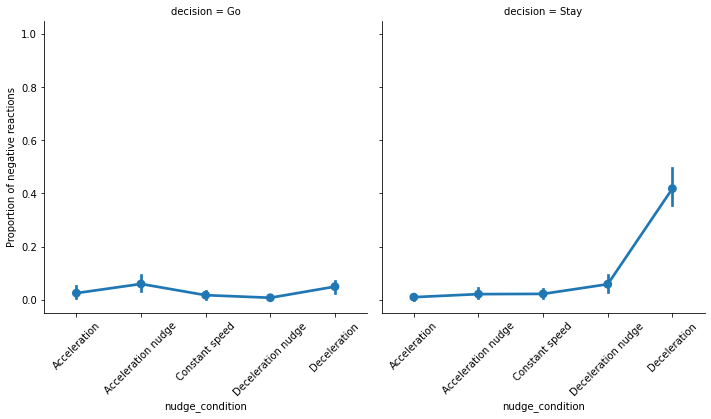

In [18]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", col="decision", kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")

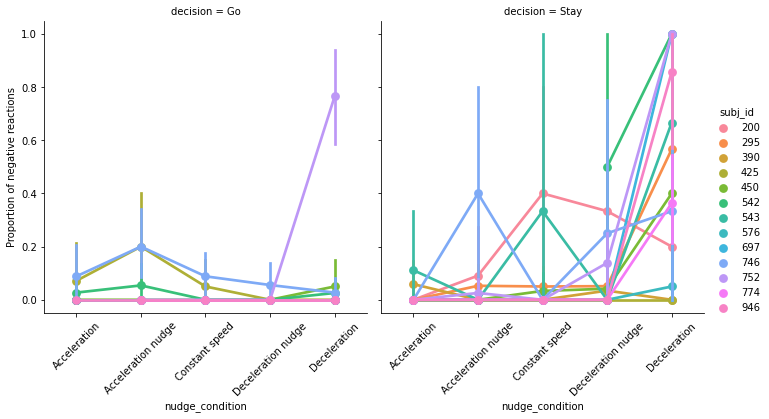

In [19]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", col="decision", kind="point", hue="subj_id",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")